In [1]:
import gym
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import random
import theano
import theano.tensor as T
from theano.gradient import grad_clip
from theano.compile.nanguardmode import NanGuardMode
import lasagne
from lasagne.layers import InputLayer, DenseLayer, Conv2DLayer, FlattenLayer, ReshapeLayer, MaxPool2DLayer, DropoutLayer
from lasagne.nonlinearities import tanh, softmax, rectify, LeakyRectify
from lasagne.objectives import squared_error
import scipy
import collections
import cPickle as pickle

Using gpu device 0: GeForce GT 620M (CNMeM is enabled with initial size: 30.0% of memory, cuDNN not available)


In [3]:
class ReplayMemory:
    def __init__(self, input_size, items = 10):
        # caches
        self._state  = np.zeros((items,) + input_size, dtype = np.float32)
        self._action = np.zeros((items,1), dtype = np.int32)
        self._reward = np.zeros((items,1), dtype = np.float32)
        self._done   = np.zeros((items,1), dtype = np.bool)
        self._nextState = np.zeros((items,) + input_size, dtype = np.float32)
        
        self.pointer = 0
        self.items = items
        self.isFull = False;
        self.input_size = input_size
        
    def append(self, state, action, reward, done, nextState):
        self._state[self.pointer] = state
        self._action[self.pointer] = action
        self._reward[self.pointer] = reward
        self._done[self.pointer] = done
        self._nextState[self.pointer] = nextState
        
        self.pointer += 1
        if self.pointer >= self.items:
            self.isFull = True
            self.pointer = 0
            
    def itemsToSample(self):
        return self.items if self.isFull else self.pointer
    
    def get_batch(self, size):
        indices =  np.random.choice(self.itemsToSample(), size=size,replace=False)
        
        state = self._state[indices]
        action = self._action[indices]
        reward = self._reward[indices]
        done = self._done[indices]
        nextState = self._nextState[indices]
        return state, action, reward, done, nextState
    
    def clear(self):
        self._state[:]  = 0
        self._action[:] = 0
        self._reward[:] = 0
        self._done[:]   = 0
        self._nextState[:] = 0
        self.pointer = 0
        self.isFull = False

# Pickle helper functions
def pickleSave(object_,filename):
    with open(filename, 'wb') as f:
            pickle.dump(object_, f, protocol=pickle.HIGHEST_PROTOCOL)

def pickleLoad(filename):
    with open(filename, 'rb') as f:
        return pickle.load(f)

    
def simple_caffe_network(input_size, output_size):
    l_in = InputLayer(shape=((None, ) + input_size), name='inputLayer')
    #network = lasagne.layers.InputLayer(shape=(None, 4, screen_size[0], screen_size[1]),
    #                                    input_var=input_var)

    network = lasagne.layers.Conv2DLayer(
        l_in, num_filters=16, filter_size=(3, 3), stride=1, pad=1,
        nonlinearity=lasagne.nonlinearities.rectify,
        W=lasagne.init.HeNormal(gain='relu'))

    network = lasagne.layers.DenseLayer(
        network,
        num_units=128,
        nonlinearity=lasagne.nonlinearities.rectify,
        W=lasagne.init.HeNormal(gain='relu'))

    network = lasagne.layers.DenseLayer(
        network,
        num_units = output_size,
        nonlinearity=None,
        b=lasagne.init.Constant(.1))
    
    return network

def simple_network2(input_size, output_size):
    l_in = InputLayer(shape=((None, ) + input_size), name='inputLayer')
    #network = lasagne.layers.InputLayer(shape=(None, 4, screen_size[0], screen_size[1]),
    #                                    input_var=input_var)

    network = lasagne.layers.Conv2DLayer(
        l_in, num_filters=16, filter_size=(3, 3),
        nonlinearity=lasagne.nonlinearities.rectify,
        W=lasagne.init.HeNormal(gain='relu'))
    
    network = lasagne.layers.Conv2DLayer(
        l_in, num_filters=16, filter_size=(3, 3),
        nonlinearity=lasagne.nonlinearities.rectify,
        W=lasagne.init.HeNormal(gain='relu'))
    
    network = MaxPool2DLayer(network, 2)
    
    network = lasagne.layers.Conv2DLayer(
        l_in, num_filters=16, filter_size=(3, 3),
        nonlinearity=lasagne.nonlinearities.rectify,
        W=lasagne.init.HeNormal(gain='relu'))
    
    network = MaxPool2DLayer(network, 2)
    
    network = lasagne.layers.Conv2DLayer(
        l_in, num_filters=16, filter_size=(3, 3),
        nonlinearity=lasagne.nonlinearities.rectify,
        W=lasagne.init.HeNormal(gain='relu'))
    
    network = DropoutLayer(network, p=0.5)

    network = lasagne.layers.DenseLayer(
        network,
        num_units=128,
        nonlinearity=lasagne.nonlinearities.rectify,
        W=lasagne.init.HeNormal(gain='relu'))

    network = lasagne.layers.DenseLayer(
        network,
        num_units = output_size,
        nonlinearity=None,
        b=lasagne.init.Constant(.1))
    
    return network

def simple_network3(input_size, output_size):
    network = InputLayer(shape=((None, ) + input_size), name='inputLayer')

    network = lasagne.layers.Conv2DLayer(
        network, num_filters=16, filter_size=(3, 3),
        nonlinearity=lasagne.nonlinearities.rectify,
        W=lasagne.init.HeNormal(gain='relu'))
    
    network = lasagne.layers.Conv2DLayer(
        network, num_filters=16, filter_size=(3, 3),
        nonlinearity=lasagne.nonlinearities.rectify,
        W=lasagne.init.HeNormal(gain='relu'))

    network = lasagne.layers.Conv2DLayer(
        network, num_filters=16, filter_size=(7, 7), stride=2,
        nonlinearity=lasagne.nonlinearities.rectify,
        W=lasagne.init.HeNormal(gain='relu'))
    
    network = DropoutLayer(network, p=0.5)

    network = lasagne.layers.Conv2DLayer(
        network, num_filters=32, filter_size=(3, 3),
        nonlinearity=lasagne.nonlinearities.rectify,
        W=lasagne.init.HeNormal(gain='relu'))
    
    network = MaxPool2DLayer(network, 2)
    
    network = lasagne.layers.Conv2DLayer(
        network, num_filters=32, filter_size=(3,3),
        nonlinearity=lasagne.nonlinearities.rectify,
        W=lasagne.init.HeNormal(gain='relu'))
    
    network = MaxPool2DLayer(network, 2)

    network = lasagne.layers.Conv2DLayer(
        network, num_filters=64, filter_size=(5,5),
        nonlinearity=lasagne.nonlinearities.rectify,
        W=lasagne.init.HeNormal(gain='relu'))

    print "---------------"
    print lasagne.layers.get_output_shape(network)

    network = lasagne.layers.DenseLayer(
        network,
        num_units=128,
        nonlinearity=lasagne.nonlinearities.rectify,
        W=lasagne.init.HeNormal(gain='relu'))

    network = lasagne.layers.DenseLayer(
        network,
        num_units = output_size,
        nonlinearity=None,
        b=lasagne.init.Constant(.1))
    
    return network

# Network function, to be passed to the DeepQNetwork
def test_network(input_size, output_size):
    l_in = InputLayer(shape=((None, ) + input_size), name='inputLayer')
    l_conv = Conv2DLayer(incoming = l_in, num_filters=32, filter_size=(8, 8), nonlinearity=rectify, W=lasagne.init.HeNormal(gain='relu'), stride=4, pad=2,b=lasagne.init.Constant(.1))
    
    #l_conv = DropoutLayer(l_conv) # this seems to remove too much
    #l_conv = Conv2DLayer(incoming = l_conv, num_filters=32, filter_size=(5, 5), nonlinearity=rectify,W=lasagne.init.HeNormal(gain='relu'))

    l_conv = Conv2DLayer(incoming = l_conv, num_filters=64, filter_size=(4, 4), nonlinearity=rectify,W=lasagne.init.HeNormal(gain='relu'), stride=2,b=lasagne.init.Constant(.1))
    l_conv = DropoutLayer(l_conv, p=0.5)
    l_conv = Conv2DLayer(incoming = l_conv, num_filters=64, filter_size=(3, 3), nonlinearity=rectify,W=lasagne.init.HeNormal(gain='relu'), stride=1, b=lasagne.init.Constant(.1))
    l_conv = MaxPool2DLayer(l_conv, 2)
    l_hid = DenseLayer(incoming = l_conv, num_units = 256, nonlinearity=LeakyRectify(), name='denseLayer',W=lasagne.init.HeNormal(gain='relu'),b=lasagne.init.Constant(.1))
    l_hid = DenseLayer(incoming = l_hid,  num_units = 256, nonlinearity=rectify, name='denseLayer',W=lasagne.init.HeNormal(gain='relu'),b=lasagne.init.Constant(.1))
    l_out = DenseLayer(incoming = l_hid,  num_units = output_size, nonlinearity=None, name='outputLayer',b=lasagne.init.Constant(.1))
    return l_out

In [4]:
class DeepQNetwork:
    def __init__(self, input_size, output_size, build_network = test_network,
                 discount = 0.99,
                 learningRate = 0.001,
                 frozen_network_update_time = 1000):
        
        print "Initializing new Q network"
        
        self.input_size = input_size
        self.output_size = output_size
        self.discount = discount
        self.learningRate = learningRate
        
        self.frozen_network_update_time = frozen_network_update_time;
        self.frozen_timer = 0;
        self.epoch = 0
        
        # logging variables
        self.log = {"batchMeanQValue":[],"batchMeanTargetQValue":[], "cost":[],'performance':[]}
        
        # symbolic inputs
        sym_state = T.tensor4('state') #Batchsize, channels, X, Y
        sym_action = T.icol('action')
        sym_reward = T.col('reward')
        sym_isDone = T.bcol('isDone')
        sym_nextState = T.tensor4('nextState')
        
        # networks
        self.network = build_network(input_size, output_size)
        self.frozen_network = build_network(input_size, output_size)
        self.update_frozen_network()
        
        # forward pass
        print "Compiling forward passes"
        self.forward_pass = theano.function([sym_state],
                                            lasagne.layers.get_output(self.network,
                                                                      sym_state,
                                                                      deterministic=True))
        
        self.frozen_forward_pass = theano.function([sym_state],
                                            lasagne.layers.get_output(self.frozen_network,
                                                                      sym_state,
                                                                      deterministic=True))
        
        clipped_reward = T.clip(sym_reward,-1,1)
        #cost function definition
        cost, error, q_action, q_target = self.build_cost_function(sym_state,
                                                              sym_action,
                                                              clipped_reward,
                                                              sym_isDone,
                                                              sym_nextState)
               
        params = lasagne.layers.get_all_params(self.network, trainable=True)
        update_function = lasagne.updates.rmsprop(cost, params, learning_rate=self.learningRate)
        
        # training function
        print "Compiling training function"
        self._train = theano.function([sym_state, sym_action, sym_reward, sym_isDone, sym_nextState],
                                        [cost, error, q_action, q_target],
                                        updates=update_function)
        
    def build_cost_function(self, state, action, reward, isDone, nextState):
        # forward pass state, action pairs to find network output
        q_values = lasagne.layers.get_output(self.network, state, deterministic=False)
        actionmask = T.eq(T.arange(self.output_size).reshape((1, -1)), action)
        q_action = T.sum(actionmask * q_values, axis = 1, keepdims=True)
        
        # forward pass next state,max action + true reward to find target on frozen network
        #should this be nondeterministic as well?
        q_next = T.max(lasagne.layers.get_output(self.frozen_network, nextState), axis = 1, keepdims=True);
        q_target = reward + self.discount*((1-isDone) * q_next)
        
        # determine cost as mean squared error
        error = q_target - q_action
        cost = T.mean( 0.5 * error ** 2 + np.abs(error))
        
        
        loss = cost + 1e-12*lasagne.regularization.regularize_network_params(self.network, lasagne.regularization.l1)
        
        return loss, error, q_action, q_target
        
    def update_frozen_network(self):
        print "Update frozen network"
        lasagne.layers.set_all_param_values(self.frozen_network, lasagne.layers.get_all_param_values(self.network))
        
    def getNetworkParameters(self):
        return lasagne.layers.get_all_param_values(self.network)
    
    def setNetworkParameters(self, parameter_values):
        lasagne.layers.set_all_param_values(self.network, parameter_values)
        
    def saveNetwork(self, filename):
        obj = {}
        obj['log'] = self.log
        obj['frozen_timer'] = self.frozen_timer
        obj['epoch'] = self.epoch
        obj['networkParameters'] = self.getNetworkParameters()
        with open(filename, 'wb') as f:
            pickle.dump(obj, f, protocol=pickle.HIGHEST_PROTOCOL)
    
    def loadNetwork(self, filename):
        with open(filename, 'rb') as f:
            obj = pickle.load(f)
            self.log = obj['log']
            self.frozen_timer = obj['frozen_timer']
            self.epoch = obj['epoch']
            self.setNetworkParameters(obj['networkParameters'])
            self.update_frozen_network()
    
    def train(self, state, action, reward, isDone, nextState):
        self.epoch += 1
        # Update frozen network check
        self.frozen_timer += 1
        if self.frozen_timer > self.frozen_network_update_time:
            self.update_frozen_network()
            self.frozen_timer = 0
        
        # Train
        cost, error, q_action, q_target = self._train(state, action, reward, isDone, nextState)
        
        # Log
        self.log['batchMeanQValue'].append(np.mean(q_action, axis = 0))
        self.log['batchMeanTargetQValue'].append(np.mean(q_target, axis = 0))
        self.log['cost'].append(cost)
        
        return cost, error, q_action, q_target

    def eval(self, state):
        return self.forward_pass(state[None,:])
    
    def evalAll(self, state):
        return self.forward_pass(state)
    
    def evalFrozen(self, state):
        return self.frozen_forward_pass(state[None,:])

In [5]:
class Agent:
    def __init__(self, envname,
                 Qfunction = None,
                 batch_size = 32,
                 cropout = (32,-16,8,-8),
                 input_size = (1,128,128),
                 action_space_size = 4,
                 replay_memory_size = 1024,
                 build_network = test_network,
                 discount = 0.99):
        
        self.cropout = cropout
        self.input_size = input_size
        self.screen_size = input_size[1:]
        self.batch_size = batch_size
        self.action_space_size = action_space_size
        self.environment = gym.make(envname)
        self.stateVector = collections.deque(maxlen=self.input_size[0])
        
        if Qfunction == None:
            self.Qfunction = DeepQNetwork(input_size  = input_size,
                                          output_size = action_space_size,
                                          build_network = build_network,
                                          discount = discount)
        else:
            self.Qfunction = Qfunction
        
        self.replay = ReplayMemory(input_size, replay_memory_size)
        
        self.reset()
        
    def reset(self):
        state = self.preprocessState(self.environment.reset())
        # clean history
        self.stateVector.clear();
        for i in range(self.stateVector.maxlen):
            self.stateVector.append(state)
            
        return state
    
    def saveNetwork(self, filename):
        with open(filename, 'wb') as f:
            pickle.dump(self.Qfunction, f, protocol=pickle.HIGHEST_PROTOCOL)
        
    def preprocessState(self, state):
        # Crop
        stateProcessed = state[self.cropout[0]:self.cropout[1],self.cropout[2]:self.cropout[3],:]
        # Resize
        stateProcessed = scipy.misc.imresize(stateProcessed, self.screen_size, interp='bilinear')
        # RGB -> BW and normalize
        stateProcessed = np.sum(stateProcessed, axis=2) / 768.0
        return stateProcessed.astype(np.float32)
    
    def step(self, action):
        (state, reward, done, info) = self.environment.step(action)
        self.stateVector.append(self.preprocessState(state))
        return (self.stateVector, reward, done, info, state)
    
    def getAction(self, epsilon = None, set_ = None):   
        # Be greedy or random
        if np.random.uniform(0,1) >= epsilon:
            action = self.Qfunction.eval(np.array(self.stateVector)).argmax()
        else:
            if set_ and np.random.uniform(0,1) > 0.05:
                action = np.random.choice(set_)
            else:
                action = np.random.randint(self.action_space_size)
        
        return action
    
    def testPerformance(self, episodes, Tmax = 10000, epsilon = 0.05, render = False, frameskip = 1):
        averageEpisodeReward = 0
        averageEpisodeTime = 0
        actions = []
        
        for episode in range(episodes):
            self.reset()

            for t in range(Tmax):
                if render:
                    self.environment.render()
                
                action = self.getAction(epsilon = 0.05)
                actions.append(action)
                
                for i in range(frameskip):
                    (currentState, reward, done, info, state) = self.step(action)
                    averageEpisodeReward += reward

                if done:
                    break
        
            averageEpisodeTime +=t
        
        if render:
            self.environment.render(close=True)
        
        actionDistribution = collections.Counter(actions)
        averageEpisodeReward /= episodes
        averageEpisodeTime /= episodes
        
        self.Qfunction.log['performance'].append({'epoch':self.Qfunction.epoch,
                                             'episodes':episodes,
                                             'Tmax':Tmax,
                                             'epsilon':epsilon,
                                             'averageEpisodeTime':averageEpisodeTime,
                                             'averageEpisodeReward':averageEpisodeReward,
                                             'actionDistribution':actionDistribution})
        
        return averageEpisodeTime, averageEpisodeReward, actionDistribution        
        
    def recordReplay(self, episodes, Tmax = 1000000, epsilon = 0.3, frameskip = 1, replayskip = 1, actionset = None):
        if episodes > 1:
            print "Recording %u episodes with epsilon %1.3f" % (episodes, epsilon) 
        # metrics
        averageEpisodeReward = 0
        averageEpisodeTime = 0
        for episode in range(episodes):
            self.reset()
            if episode % 50 == 1:
                print "Recording: episode %d\t avg time %s\t avg reward %s" % (episode,
                            averageEpisodeTime/(episode+1), averageEpisodeReward/(episode+1) )
            # for custom reward when loosing the ball
            oldFrame = self.environment._buffer[5:15,100:112,0]
            for t in range(Tmax):
                # extract current state
                state = np.array(self.stateVector)
                
                # choose action via epsilon greedy method
                action = self.getAction(epsilon, actionset)
                
                # perform action for [frameskip] steps
                totalReward = 0
                
                for i in range(frameskip):
                    (nextState, reward, done, _, s) = agent.step(action)
                    totalReward += reward
                    
                    # custom reward modifiers
                    # If loose ball (life)
                    if (s[5:15,100:112,0] - oldFrame).any():
                        totalReward -= 1
                    oldFrame = s[5:15,100:112,0]
                    
                    # If done
                    if done:
                        totalReward -= 1
                        break
                
                averageEpisodeReward += totalReward
                
                #extract nextState
                nextState = np.array(self.stateVector)
                
                if totalReward != 0 or done or (t + episode) % replayskip == 0:
                    # add step to replay memory
                    self.replay.append(state, action, totalReward, done, nextState)
                    
                # continue to next episode/game
                if done:                    
                    break;
            
            self.assignTrueDiscountedFutureReward(self.replay.pointer-1, Tmax, self.Qfunction.discount)
            
            averageEpisodeTime += t
        
        averageEpisodeReward /= episodes
        averageEpisodeTime /= episodes
        
        return averageEpisodeTime, averageEpisodeReward
    
    def assignTrueDiscountedFutureReward(self, endTime, Tmax, discount):
        i = endTime
        if i == -1:
            i = self.replay.items
            
        rtrace = 0.0
        for x in range(Tmax):
            rtrace += self.replay._reward[i]
            self.replay._reward[i] = rtrace
            self.replay._done[i] = True

            i -= 1
            rtrace *= discount
            if i == -1 and self.replay.isFull:
                i = self.replay.items - 1
            if self.replay._done[i]:
                break
    
    def loadRecordedDataToReplay(self, filename):
        print "Loading replay data from %s" % filename
        with open(filename, 'rb') as f:
            data = pickle.load(f)
            
            # clean history
            self.stateVector.clear();
            for i in range(self.stateVector.maxlen):
                self.stateVector.append(self.preprocessState(data[0][0]))
                
            for t in data:
                # unpack (state,action,reward,done)
                state = t[0]
                action = t[1]
                reward = t[2]
                done = t[3]
                
                # extract current state
                stateA = np.array(self.stateVector)
                
                self.stateVector.append(self.preprocessState(state))
                
                #extract nextState
                nextStateA = np.array(self.stateVector)
                
                # add step to replay memory
                self.replay.append(stateA, action, reward, done, nextStateA)
                
                # continue to next episode/game 
                if done == 2:
                    # clean history
                    self.stateVector.clear();
                    for i in range(self.stateVector.maxlen):
                        self.stateVector.append(self.preprocessState(data[0][0]))       
                    
    def trainFromReplay(self, batch_size):
        # check replay memory size
        if self.replay.itemsToSample() > self.batch_size:

            # sample random minibatch of transitions from D
            state, action, reward, done, nextState = self.replay.get_batch(batch_size)

            # train
            cost = self.Qfunction.train(state, action, reward, done, nextState)

            # log
            if self.Qfunction.epoch % 500 == 0:
                print self.Qfunction.epoch, cost[0]

def epsilon_scheme_linear(t, tstart, estart, tend, eend):
    if t <= tstart:
        return estart
    elif t >= tend:
        return eend
    r = (t-tstart)/float(tend-tstart)
    return (1-r)*estart + r*eend

In [ ]:
# Training test, Q values should converge to targets
agent = Agent("Breakout-v0", input_size = (2,80,80), Qfunction = DeepQNetwork((2,80,80), 4, build_network = test_network,
                                                      frozen_network_update_time = 5000, learningRate = 0.001))

# Setup
act = np.matrix([0, 1, 2, 3] ,dtype=np.int32).transpose()
done = np.matrix([0, 0, 0, 0] ,dtype=np.bool).transpose()
r = np.matrix([1, 1, 1, 1] ,dtype=np.float32).transpose()
state = np.array(agent.stateVector)[None,:]
state = np.concatenate((state,state,state,state), axis=0)

print "input shapes"
print state.shape
print act.shape
print done.shape
print r.shape

print [(x.max(), x.min(), x.mean(), x.shape) for x in agent.Qfunction.getNetworkParameters()]
print agent.Qfunction.train(state, act, r, done, state)

# Run
buf = []
for i in range(1000):
    r = np.matrix([ np.sin(i/100.0)+5 , np.cos(i/100.0)+10 , -10 , 5],dtype=np.float32).transpose()
    buf.append(agent.Qfunction.train(state, act, r, done, state))

# Assert
plt.figure(figsize=(15, 3))
plt.plot(np.matrix([x[2][:,0] for x in buf]))
plt.plot(np.matrix([x[3][:,0] for x in buf]))
plt.xlabel('epoch')
plt.ylabel('Q(s)')
plt.grid(True)
plt.figure(figsize=(15, 3))
plt.plot(np.array([x[0] for x in buf]))
plt.xlabel('epoch')
plt.ylabel('cost')
plt.grid(True)

In [ ]:
#initialize agent
agent = Agent("Breakout-v0", replay_memory_size = 2**10, input_size = (3,64,64), build_network = simple_network2,
              cropout = (96,-8,8,-8))
avgTime, avgReward = agent.recordReplay(episodes = 50, epsilon = 1, Tmax = 1600)
agent.Qfunction.loadNetwork("experiments/runningLookahead_l2/QNetwork310.bin")

In [ ]:
# load network parameters into agent
agent = Agent("Alien-v0", replay_memory_size = 2**16, input_size = (4,64,64),
              build_network = test_network, cropout = (8,-16,16,-16), action_space_size = 7)

agent.Qfunction.loadNetwork("experiments/QNetworkAlien100.bin")

In [ ]:
# load network parameters into agent
agent = Agent("Alien-v0", replay_memory_size = 2**16, input_size = (4,64,64),
              build_network = test_network, cropout = (8,-16,16,-16), action_space_size = 7)

agent.Qfunction.loadNetwork("experiments/QNetworkAlien100.bin")


In [ ]:
# load network parameters into agent
agent.Qfunction.loadNetwork("experiments/Breakout-221116/QNetwork260.bin")

In [ ]:
# save network parameters
agent.Qfunction.saveNetwork("network_good2.dat")

In [22]:
def epsilon_scheme_linear(t, tstart, estart, tend, eend):
    if t <= tstart:
        return estart
    elif t >= tend:
        return eend
    r = (t-tstart)/float(tend-tstart)
    return (1-r)*estart + r*eend

# Train N-step DeepQ agent

In [ ]:
#agent = Agent("Breakout-v0", replay_memory_size = 2**16, input_size = (3,64,64), build_network = test_network,
#              cropout = (96,-16,8,-8))

if False or 'agent' not in globals():
    agent = Agent("Breakout-v0", replay_memory_size = 2**16, input_size = (3,64,64), build_network = simple_network2,
                  cropout = (96,-8,8,-8))
    avgTime, avgReward = agent.recordReplay(episodes = 102, epsilon = 1, Tmax = 1600)

# Do supervised learning
agent.Qfunction.frozen_network_update_time = 1000000
for i in range(300):
    agent.testPerformance(10)
    print "Performance: %s " % agent.Qfunction.log['performance'][-1]
    avgTime, avgReward = agent.recordReplay(episodes = 10,
                                            epsilon = epsilon_scheme_linear(agent.Qfunction.epoch, 10000, 1, 60000, 0.1),
                                            frameskip = 1, replayskip = 1, Tmax = 1600)
    
    for i in range(500):
        agent.trainFromReplay(32)
    
agent.Qfunction.update_frozen_network();

# Train DeepQ agent

In [ ]:
#agent = Agent("Breakout-v0", replay_memory_size = 2**16, input_size = (3,64,64), build_network = test_network,
#              cropout = (96,-16,8,-8))
#avgTime, avgReward = agent.recordReplay(episodes = 152, epsilon = 1,frameskip = 1, replayskip = 1, Tmax = 1600)

# agent training
print "--- Recording ---"
#agent.recordReplay(episodes = 50, epsilon = 1)
#agent.trainWithReplay(episodes = 5 , Tmax = 100000000, epsilon=1)
print "--- Training ---"
# set update frequency of the frozen network
agent.Qfunction.frozen_network_update_time = 10000
for game in range(5000):
    #print "training epoch %u" % a
    t, reward = agent.recordReplay(episodes=1, Tmax = 800,
                                   epsilon=epsilon_scheme_linear(agent.Qfunction.epoch, 50000, 1, 500000, 0.1),
                                   frameskip = 1, replayskip = 8)
    for i in range(min(t,500)):
        agent.trainFromReplay(32)
    
    if game % 25 == 0:
        agent.testPerformance(10)
        print "Performance: %s " % agent.Qfunction.log['performance'][-1]
    # Record new samples with current epsilon greedy Q value strategy
    #if epoch % 1000 == 999:
    #    avgTime, avgReward = agent.recordReplay(episodes = 50, epsilon = 1 - epoch/10000.0, frameskip = 1, replayskip = 4)
    #    print "avg time %s,\t avg reward %s" % (avgTime, avgReward)

# Calculate Q(s,a) from items in replay memory and plot heatmaps

In [54]:
print agent.replay.itemsToSample()
Qval = agent.Qfunction.evalAll(agent.replay._state[i*2000:(i+1)*2000])#agent.replay.itemsToSample()])

64281


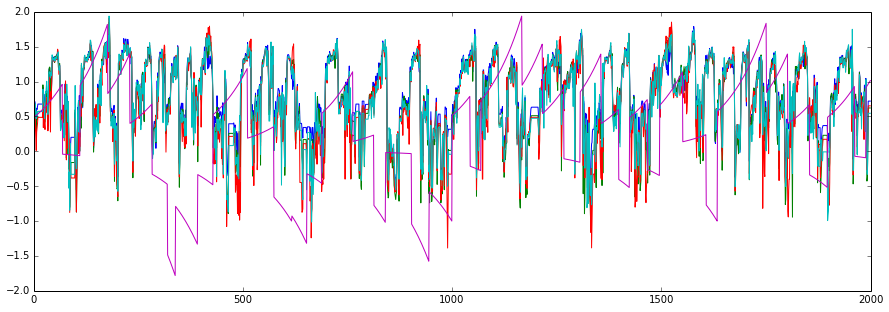

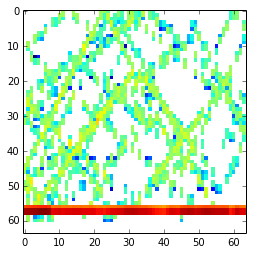

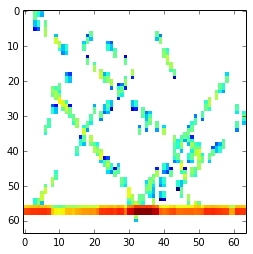

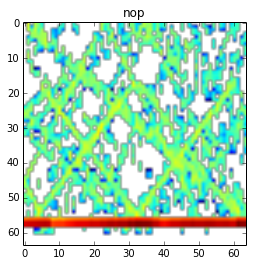

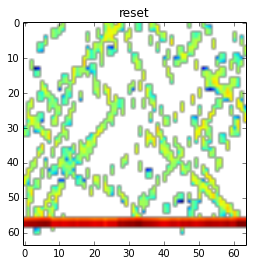

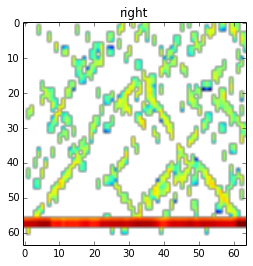

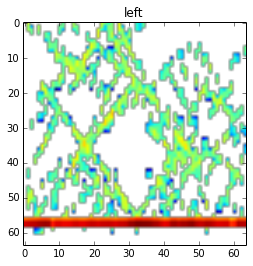

In [68]:
mask = Qval.max(axis=1)
plt.figure(figsize=(15, 5))
plt.plot(Qval)
plt.plot(agent.replay._reward[0:len(mask)])
states = agent.replay._state[0:len(mask)]
plt.figure()
plt.imshow(np.log(states[mask>1.2].mean(axis = (0,1))), interpolation='none')
plt.figure()
plt.imshow(np.log(states[mask<0].mean(axis = (0,1))), interpolation='none')

heatmaps = []
for i in range(4):
    heatmaps.append(states[Qval.argmax(axis = 1)==i].sum(axis = (0,1)))
                    
heatmaps = np.log(np.array(heatmaps))
#heatmaps = (heatmaps / heatmaps.sum(axis=0)[np.newaxis, :])
#heatmaps[np.isnan(heatmaps)] = 0

actionlabels = ['nop', 'reset', 'right', 'left']
for i,label in enumerate(actionlabels):
    plt.figure()
    plt.title(label)
    plt.imshow(heatmaps[i,:,:])
    plt.savefig("ActionHeatmap%s.png" % label)


# Plot Parameter values

Layer 1 filter values


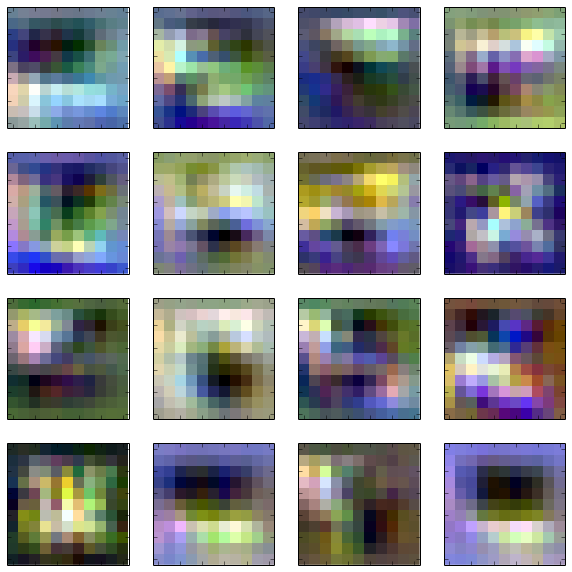

In [134]:
parameterValues = [p.get_value() for p in lasagne.layers.get_all_params(agent.Qfunction.network, trainable=True) if p.name=='W']

def conv4d(f,k, stride=1, mode = 'full'):
    out = np.zeros((k.shape[0], f.shape[1], f.shape[2] + k.shape[2] -1, f.shape[3] + k.shape[3] -1))
    for i in range(k.shape[0]):
        if not k.shape[1] == f.shape[0]:
            print "ERROR wrong size"
        for j in range(f.shape[0]):
            for l in range(f.shape[1]):
                out[i,l,:,:] += scipy.signal.convolve2d(k[i,j,:,:], f[j,l,:,:],mode)
    return out

filters = conv4d(parameterValues[0],parameterValues[1])
filters = conv4d(filters,parameterValues[2])

num_filters = filters.shape[0]
n = int(np.ceil(num_filters**0.5))
fig, ax = plt.subplots(n,n, figsize=(10,10))
print "Layer 1 filter values"
j = 0
for i in range(n):
    for j in range(n):
        if i*n+j < filters.shape[0]:
            f = np.transpose(filters[i*n+j,:,:,:], (1,2,0))
            f = (f - f.min(axis=(0,1))[np.newaxis, np.newaxis,:]) / ((f.max(axis=(0,1)) - f.min(axis=(0,1)))[np.newaxis, np.newaxis,:])
            ax[i,j].imshow(f, cmap='gray', interpolation='none')
            ax[i,j].xaxis.set_major_formatter(plt.NullFormatter())
            ax[i,j].yaxis.set_major_formatter(plt.NullFormatter())
            
plt.savefig("breakoutKernels")
            


# Record playing videos and plot actions

[2016-11-26 15:08:11,980] Clearing 4 monitor files from previous run (because force=True was provided)
[2016-11-26 15:08:12,082] Starting new video recorder writing to /tmp/breakout-experiment-3/openaigym.video.13.12740.video000000.mp4
[2016-11-26 15:08:51,915] Finished writing results. You can upload them to the scoreboard via gym.upload('/tmp/breakout-experiment-3')


Total Reward: 8.0


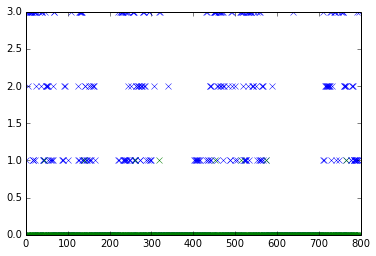

In [87]:

agent.environment.monitor.start('/tmp/breakout-experiment-3', force=True)
agent.environment.reset()
a = []
Qvals = []
totalReward = 0
rewards = []
for _ in range(800):
    agent.environment.render()
    action = agent.getAction(epsilon = 0.05)
    a.append(action)
    for i in range(1):
        (currentState, reward, done, info, state) = agent.step(action)
        Qvals.append(agent.Qfunction.eval(np.array(agent.stateVector)))
        totalReward += reward
        rewards.append(reward)
    if done:
        break
    #print action
agent.environment.monitor.close()
agent.environment.render(close=True)
print "Total Reward: %s" % totalReward
plt.plot(a,'x')
plt.plot(rewards,'x')

In [ ]:
agent.environment.monitor.close()
plt.figure(figsize=(17, 5))
plt.plot(agent.replay._reward[0:50000])
plt.plot(agent.replay._done[0:50000])

# Plot log statistics from network file

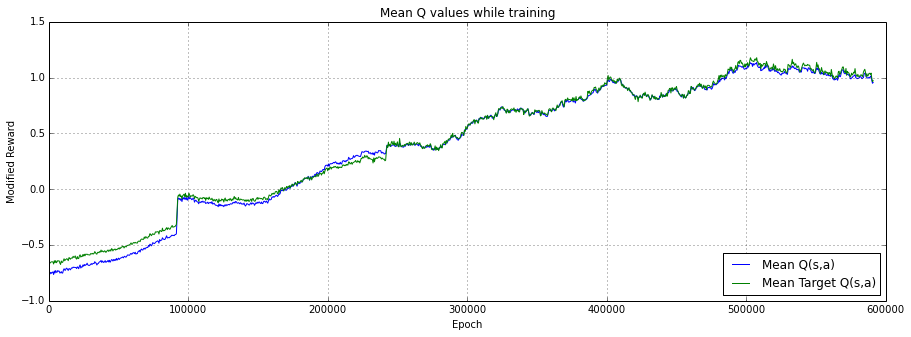

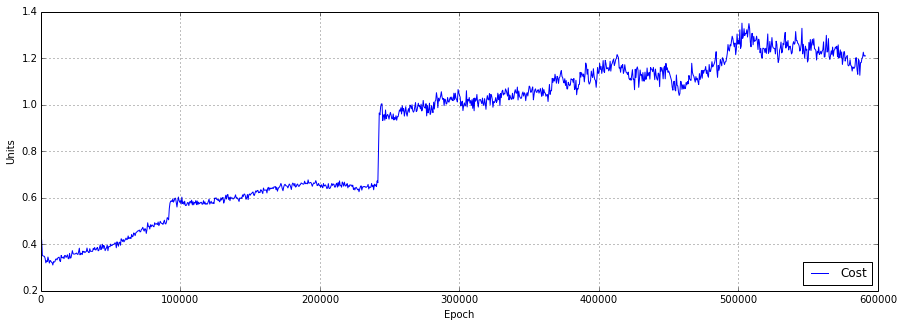

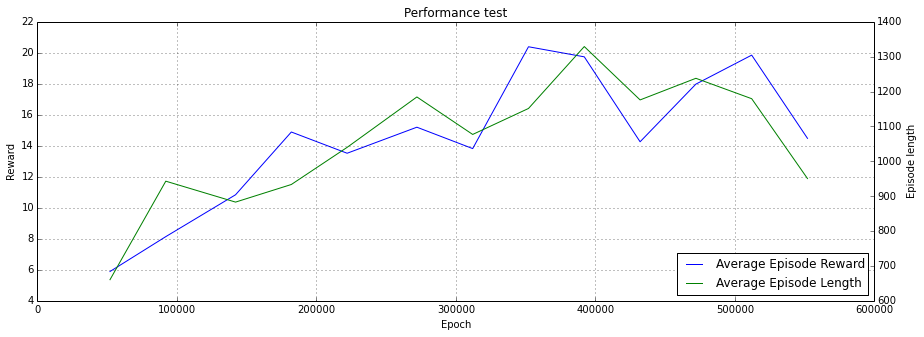

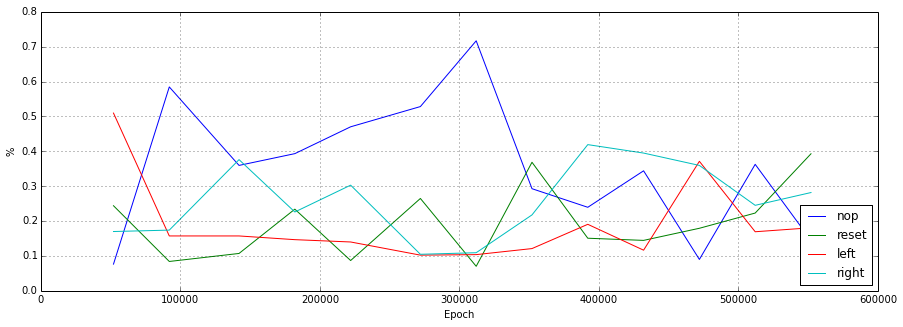

In [19]:
log = pickleLoad("experiments/network3/QNetwork280.bin")['log']
kernel_size = 50
filter_kernel = np.ones(kernel_size)/kernel_size

batchMeanQTarget = np.convolve(
    np.array(log['batchMeanTargetQValue']),
    filter_kernel, mode='same')[kernel_size:-kernel_size:kernel_size]
batchMeanQ = np.convolve(
    np.array(log['batchMeanQValue']),
    filter_kernel, mode='same')[kernel_size:-kernel_size:kernel_size]
cost = np.convolve(
    np.array(log['cost']),
    filter_kernel, mode='same')[kernel_size:-kernel_size:kernel_size]
epochLog = np.array(log['epoch'])[kernel_size:-kernel_size:kernel_size]

plt.figure(figsize=(15, 5))
plt.plot(epochLog, batchMeanQ)
plt.plot(epochLog, batchMeanQTarget)
plt.grid(True)
plt.title('Mean Q values while training')
plt.legend(['Mean Q(s,a)', 'Mean Target Q(s,a)'],'lower right')
plt.xlabel('Epoch')
plt.ylabel('Modified Reward')
plt.savefig("meanQTrain.png")

plt.figure(figsize=(15, 5))
plt.plot(epochLog, cost)
plt.grid(True)
plt.legend(['Cost'],'lower right')
plt.ylabel('Units')
plt.xlabel('Epoch')

kernel_size = 2
filter_kernel = np.ones(kernel_size)/kernel_size

performanceLog = log['performance']
epochLogPerformance = [x['epoch'] for x in performanceLog][kernel_size:-kernel_size:kernel_size]
avgEpisodeReward = np.convolve(
    np.array([x['averageEpisodeReward'] for x in performanceLog]),
    filter_kernel, mode='same')[kernel_size:-kernel_size:kernel_size]
avgEpisodeTime = np.convolve(
    np.array([x['averageEpisodeTime'] for x in performanceLog]),
    filter_kernel, mode='same')[kernel_size:-kernel_size:kernel_size]
        
fig, ax1 = plt.subplots(figsize=(15, 5))
l1, = plt.plot(epochLogPerformance, avgEpisodeReward)
plt.xlabel('Epoch')
plt.ylabel('Reward')
plt.grid(True)
ax2 = ax1.twinx()
l2, = ax2.plot(epochLogPerformance, avgEpisodeTime, 'g')
plt.title('Performance test')
plt.legend([l1,l2], ['Average Episode Reward','Average Episode Length'],'lower right')
plt.xlabel('Epoch')
plt.ylabel('Episode length')
plt.savefig("Performance.png")


plt.figure(figsize=(15, 5))
dist = np.array([x['actionDistribution'].values() for x in performanceLog], dtype=np.float32)
dist = np.divide(dist.transpose(),dist.sum(axis=1).transpose())
i = 0
for action in dist:
    plt.plot(epochLogPerformance,np.convolve(action,filter_kernel, mode='same')[kernel_size:-kernel_size:kernel_size])
    i += 1
plt.grid(True)
plt.xlabel('Epoch')
plt.ylabel('%')
plt.legend(['nop','reset','left','right'],'lower right')
plt.savefig("actionDistributionPerformance.png")

# Inspect filters

Layer 1 filter values


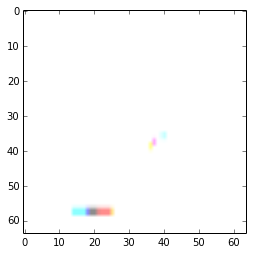

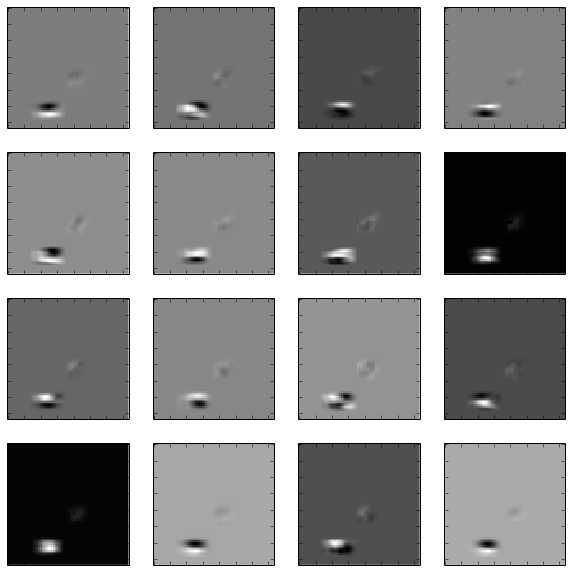

In [145]:
frame = agent.replay._state[182,:,:,:]
plt.figure()
plt.imshow(1-np.transpose(frame, (1,2,0)))
plt.savefig('processedFrame.png')

out = conv4d(frame[:, np.newaxis,:,:],filters)

num_filters = filters.shape[0]
n = int(np.ceil(num_filters**0.5))
fig, ax = plt.subplots(n,n, figsize=(10,10))
print "Layer 1 filter values"
j = 0
for i in range(n):
    for j in range(n):
        if i*n+j < filters.shape[0]:
            f = np.transpose(out[i*n+j,:,:,:], (1,2,0))
            f = (f - f.min(axis=(0,1))[np.newaxis, np.newaxis,:]) / ((f.max(axis=(0,1)) - f.min(axis=(0,1)))[np.newaxis, np.newaxis,:])
            ax[i,j].imshow(f[:,:,0], cmap='gray', interpolation='none')
            ax[i,j].xaxis.set_major_formatter(plt.NullFormatter())
            ax[i,j].yaxis.set_major_formatter(plt.NullFormatter())

plt.savefig('filteredFrame.png')

# Development notes
## What seems to work
* LARGE replay memory, the larger the better and no smaller than 64k entries
* Small convolution filters
* Lookahead, find the true discounted reward
* Punish loosing the ball, otherwise it wont learn to keep it
* Use L2 parameter cost, rather than L1 or no cost
* Use a mix of linear and quadrantic cost for the target
* Cropping only the bottom of the screen reduces training time due to fewer neurons firing on blocks/missing blocks
* Focus on a balanced replay. If there is only bad moves in the memory it will never learn